# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-1
    end = np.max(t2)+1
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:
tlat, tlon,ttime = readbasegps("/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/current-05052021.gpx")
    

/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/current-05052021.gpx


In [4]:
ttime[0]

datetime.datetime(2021, 5, 5, 13, 23, 39)

In [5]:
ttime[-1]

datetime.datetime(2021, 5, 5, 15, 28, 20)

In [6]:
gpxfile1 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 07.23.38 Auto.gpx"
gpxfile2 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 08.08.39 Auto.gpx"
gpxfile3 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 08.53.39 Auto.gpx"
gpxfile4 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 09.38.39 Auto.gpx"
gpxfile5 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 10.23.39 Auto.gpx"
gpxfile6 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 11.08.39 Auto.gpx"
gpxfile7 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 11.53.39 Auto.gpx"
gpxfile8 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 12.38.39 Auto.gpx"
gpxfile9 = "/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/current-05052021.gpx"



In [7]:
glon1, glat1, gtimes1 = readbasegps(gpxfile1)
glon2, glat2, gtimes2 = readbasegps(gpxfile2)
glon3, glat3, gtimes3 = readbasegps(gpxfile3)
glon4, glat4, gtimes4 = readbasegps(gpxfile4)
glon5, glat5, gtimes5 = readbasegps(gpxfile5)
glon6, glat6, gtimes6 = readbasegps(gpxfile6)
glon7, glat7, gtimes7 = readbasegps(gpxfile7)
glon8, glat8, gtimes8 = readbasegps(gpxfile8)
glon9, glat9, gtimes9 = readbasegps(gpxfile9)


/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 07.23.38 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 08.08.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 08.53.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 09.38.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 10.23.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 11.08.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 11.53.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/2021-05-05 12.38.39 Auto.gpx
/mnt/documents/Q2/AeNP4-05052021/garmin/station-marker/current-05052021.gpx


In [8]:
glat = glat1
glat.extend(glat2)
glat.extend(glat3)
glat.extend(glat4)
glat.extend(glat5)
glat.extend(glat6)
glat.extend(glat7)
glat.extend(glat8)
glat.extend(glat9)

In [9]:
glon = glon1
glon.extend(glon2)
glon.extend(glon3)
glon.extend(glon4)
glon.extend(glon5)
glon.extend(glon6)
glon.extend(glon7)
glon.extend(glon8)
glon.extend(glon9)

In [10]:
gtimes = gtimes1
gtimes.extend(gtimes2)
gtimes.extend(gtimes3)
gtimes.extend(gtimes4)
gtimes.extend(gtimes5)
gtimes.extend(gtimes6)
gtimes.extend(gtimes7)
gtimes.extend(gtimes8)
gtimes.extend(gtimes9)

In [11]:
gtimes[-1]

datetime.datetime(2021, 5, 5, 15, 28, 20)

In [12]:
gtimes[0]

datetime.datetime(2021, 5, 5, 7, 23, 38)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [13]:
## get the UTM zone
utmzone=getutm(glon[0], glat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32636'

In [14]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [15]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

## Convert time to seconds-of-day

**check time zones! Use UTC.**

In [16]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

In [17]:
gnssdayseconds[0:5]

[26618.0, 26620.0, 26621.0, 26622.0, 26623.0]

## Load  GEM2 data to be drift corrected

In [73]:
gem2inputfile = "/mnt/documents/Q2/AeNP4-05052021/transect/gem2/AeN-Q2-P4-transect-05052021-gem2-531-channel-thickness.csv"

In [74]:
gem2data = pd.read_csv(gem2inputfile)

In [75]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-05-05T07:48:37.140625           0    0.000000    0.00000  0.0   
1      2021-05-05T07:48:37.242187           1    0.000000    0.00000  0.0   
2      2021-05-05T07:48:37.335937           2    0.000000    0.00000  0.0   
3      2021-05-05T07:48:37.437500           3    0.000000    0.00000  0.0   
4      2021-05-05T07:48:37.539062           4   33.518121   79.67595  0.0   
...                           ...         ...         ...        ...  ...   
59218  2021-05-05T09:27:19.015625       59218    0.000000    0.00000  0.0   
59219  2021-05-05T09:27:19.109375       59219    0.000000    0.00000  0.0   
59220  2021-05-05T09:27:19.210937       59220    0.000000    0.00000  0.0   
59221  2021-05-05T09:27:19.312500       59221    0.000000    0.00000  0.0   
59222  2021-05-05T09:27:19.414062       59222    0.000000    0.00000  0.0   

        yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0      0.0         0.346          0.197           0.254           0.170   
1      0.0         0.137          0.158           0.189           0.161   
2      0.0         0.217          0.160           0.212           0.163   
3      0.0         0.524          0.200           0.243           0.171   
4      0.0         0.515          0.174           0.243           0.174   
...    ...           ...            ...             ...             ...   
59218  0.0        -0.145          0.136           0.277           0.188   
59219  0.0         0.127          0.184           0.269           0.179   
59220  0.0         0.207          0.183           0.253           0.179   
59221  0.0         0.310          0.157           0.221           0.180   
59222  0.0         0.383          0.135           0.228           0.186   

        f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i  f18330Hz_hcp_q  \
0               0.230           0.160            0.235             nan   
1               0.229           0.156            0.234             nan   
2               0.234           0.153            0.234             nan   
3               0.239           0.154            0.233             nan   
4               0.239           0.157            0.232             nan   
...               ...             ...              ...             ...   
59218           0.253           0.166            0.241             nan   
59219           0.252           0.162            0.242             nan   
59220           0.250           0.160            0.241             nan   
59221           0.242           0.164            0.240             nan   
59222           0.245           0.161            0.240             nan   

        f63030Hz_hcp_i   f63030Hz_hcp_q  
0                0.198            0.115  
1                0.198            0.117  
2                0.198            0.117  
3                0.197            0.115  
4                0.197            0.115  
...                ...              ...  
59218            0.197            0.170  
59219            0.196            0.172  
59220            0.195            0.172  
59221            0.194            0.169  
59222            0.194            0.168  

[59223 rows x 16 columns]

In [76]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [77]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [78]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [79]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

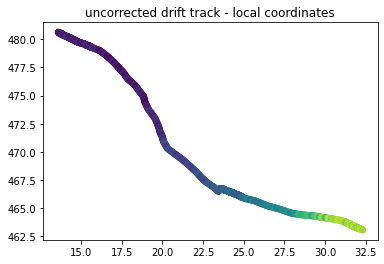

In [81]:
plt.scatter(gem2easting[2000:3000]-np.min(gem2easting), gem2northing[2000:3000]-min(gem2northing), c = f1530hz_hcp_i[2000:3000])
plt.title("uncorrected drift track - local coordinates")

In [82]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [83]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [84]:
gem2dayseconds[0]

28117.5391

In [85]:
gem2times[0]

'2021-05-05T07:48:37.539062'

In [86]:
gnssdayseconds[0]

26618.0

In [87]:
gtimes[0]

datetime.datetime(2021, 5, 5, 7, 23, 38)

In [88]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

In [89]:
gnss_trimmedtime = np.squeeze(gnss_trimmedtime)

In [90]:
gnss_trimmedtime[0]

1498

In [91]:
gnssutm = np.array(gnssutm)

In [92]:
gnssutm[0][gnss_trimmedtime]

array([1098845.38834027, 1098845.49008527, 1098845.55561866, ...,
       1099383.42896664, 1099383.65170452, 1099383.74348102])

In [93]:
gnssdayseconds = np.array(gnssdayseconds)

In [94]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [95]:
trimmedtime.size

5918

In [96]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [97]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 29min 28s, sys: 3min 59s, total: 33min 27s
Wall time: 33min 28s


In [98]:
len(timeindexes)

59204

In [99]:
len(gem2easting)

59204

In [100]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [101]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [102]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [103]:
local_gem2_east.size

59204

In [104]:
world_gem2_east = local_gem2_east + gnssutm[0][0]
world_gem2_north = local_gem2_north + gnssutm[1][0]

In [105]:
world_gem2_east.size

59204

In [106]:
gnss_gem2_match_eastings[0]

1098845.4431910014

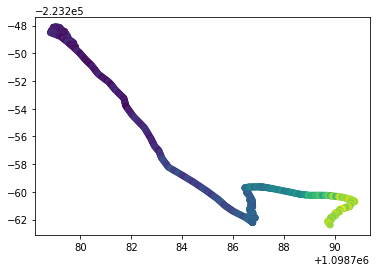

In [107]:
plt.scatter(world_gem2_east[2000:3000], world_gem2_north[2000:3000], c=f1530hz_hcp_i[2000:3000])

In [154]:
gem2_header = """AeN Q2 2021 P4 GEM2 measurements
GEM2-531 electromagnetic induction sounder
5 May 2021\nAdam Steer / Polona Itkin
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [155]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [156]:
gem2out = gem2data.copy()

In [157]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [158]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [159]:
gem2out.insert(2, "easting", world_gem2_east)

In [160]:
gem2out.insert(3, "northing", world_gem2_north)

In [161]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [162]:
gem2_output = "/mnt/documents/Q2/AeNP4-05052021/GEM2data-driftcorrected.csv"

In [163]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [164]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the Alaska Magnaprobe we need to add 8 hours to timestamps...

In [119]:
magnaprobeinputfile = "/mnt/documents/Q2/AeNP4-05052021/transect/magnaprobe/P43552_0.dat"


In [120]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [121]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [122]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values

fixedtime = []
for thetime in mprawtimes:
    try:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 9))
        
    except ValueError:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S") + timedelta(hours = 9))

mprawtimes = [datetime.strftime(thetime, "%Y-%m-%d %H:%M:%S.%f") for thetime in fixedtime]
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [123]:
mprawtimes[100]

'2021-05-05 07:58:04.080000'

In [124]:
datetime.strptime(mprawtimes[0], "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 8)

datetime.datetime(2021, 5, 5, 15, 44, 29, 550000)

In [125]:
mpdaysfixed = [day + weekdelta for day in mpdays]

NameError: name 'weekdelta' is not defined

In [126]:
mptimes

array(['07:44:29.550000', '07:44:35.010000', '07:54:24.850000', ...,
       '09:29:07.340000', '09:29:08.320000', '09:29:09.260000'],
      dtype='<U15')

In [127]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [128]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

array([27869.55, 27875.01, 28464.85, ..., 34147.34, 34148.32, 34149.26])

In [129]:
gnssdayseconds

array([26618., 26620., 26621., ..., 55698., 55699., 55700.])

In [130]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [131]:
gnssdayseconds = np.array(gnssdayseconds)

In [132]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [133]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [134]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 442 ms, sys: 337 µs, total: 443 ms
Wall time: 442 ms


In [135]:
len(timeindexes)

3055

In [136]:
len(mp_dayseconds)

3055

In [137]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [138]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [139]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [140]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

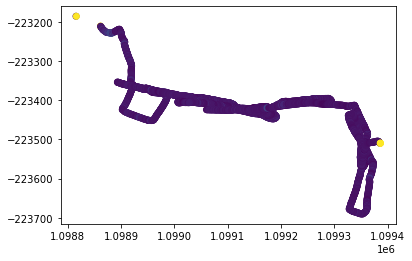

In [141]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [142]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [143]:
len(mpeasting)

3055

In [144]:
len(gnss_mp_match_eastings)

3055

Convert back to world coordinates

In [145]:
world_mp_east = local_mp_east + gnssutm[0][0]
world_mp_north = local_mp_north + gnssutm[1][0]

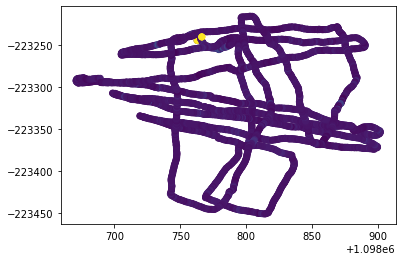

In [146]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [147]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdays[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [148]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [149]:
mp_output = "/mnt/documents/Q2/AeNP4-05052021/transect/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [165]:
mp_header = """AeN Q2 2021 P4 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
5 May 2021\nAdam Steer / Polona Itkin
Time corrected: adding 9 hours to instrument timestamps to account for time zone settings
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730

"""

In [166]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [167]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

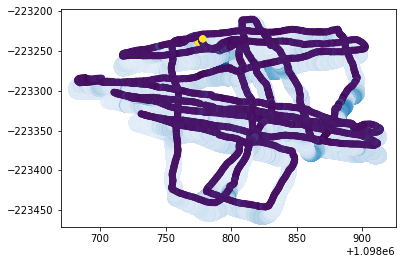

In [168]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [ ]:
cameracentrefile = "/mnt/documents/ANAFI-USA/AeNQ2/05May2021AeNQ2P4/cameracentres.csv"

In [ ]:
cameradata = pd.read_csv(cameracentrefile)

In [ ]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [ ]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [ ]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

In [ ]:
plt.scatter(cameraeasting, cameranorthing)

In [ ]:
cameradata

In [ ]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [ ]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [ ]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

In [ ]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [ ]:
cam_dayseconds[0]

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
len(cam_dayseconds)

In [ ]:
len(gnss_trimmedtime[0])

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
len(trimmedeast)

In [ ]:
min(cam_dayseconds)

In [ ]:
max(cam_dayseconds)

In [ ]:
min(gnssdayseconds)

In [ ]:
max(gnssdayseconds)

In [ ]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

In [ ]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [ ]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [ ]:
local_cam_east[0]

In [ ]:
local_cam_north[0]

In [ ]:
local_gem2_east[0]

In [ ]:
local_mp_east[0]

In [ ]:
plt.scatter(local_cam_east, local_cam_north)

In [ ]:
world_cam_east = local_cam_east + gnssutm[0][0]
world_cam_north = local_cam_north + gnssutm[1][0]

In [ ]:
world_cam_east[0]

In [ ]:
world_gem2_east[0]

In [ ]:
fig = plt.figure(figsize=(20,20))

plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP4-05052021/driftracks.png")

In [ ]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [ ]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [ ]:
cam_out = cameradata.copy()

In [ ]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [ ]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [ ]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/AeNQ2/05May2021AeNQ2P4/driftcorrected-for-exiftool.csv"

In [ ]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [ ]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

In [ ]:
cam_out['GPSLatitude'][0]

cam_o

In [ ]:
cam_out_hag = cam_out.copy()

In [ ]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [ ]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [ ]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/AeNQ2/05May2021AeNQ2P4/driftcorrected-for-exiftool-HAG.csv"

In [ ]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)